<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/65_HNSW_Vector_Search_Engine.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# 🕸️ HNSW: Jak szukać w miliardach danych?

Standardowe wyszukiwanie (Brute Force KNN) ma złożoność $O(N)$. Musisz porównać pytanie z każdym dokumentem.
HNSW to algorytm **ANN (Approximate Nearest Neighbor)**. Ma złożoność $O(\log N)$.

**Idea "Małego Świata" (Small World):**
Teoria "Sześciu stopni oddalenia" mówi, że do każdego człowieka na ziemi dotrzesz przez max 6 znajomych.
HNSW wykorzystuje to w wektorach.

Zamiast sprawdzać listę, skaczemy po grafie:
1.  Jesteśmy w punkcie A (losowym).
2.  Pytamy sąsiadów A: "Kto z was jest bliżej celu?".
3.  Przeskakujemy na najlepszego sąsiada.
4.  Powtarzamy, aż utkniemy.

Zaimplementujemy (uproszczony) algorytm **Greedy Search na Grafie**.

Mamy 500 punktów w bazie.
Szukamy sąsiada dla punktu: [0.5 0.5]


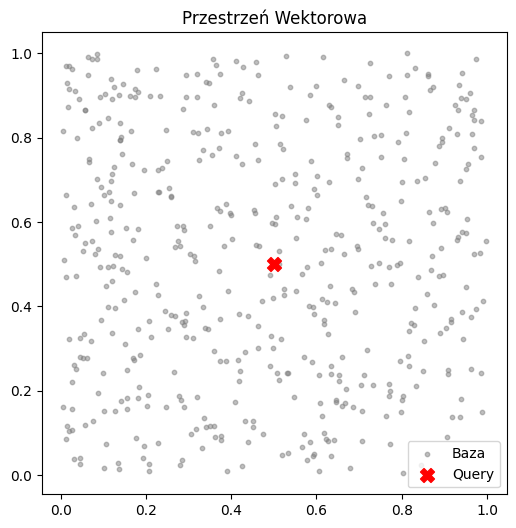

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time

# 1. GENERUJEMY DANE (Wektory 2D)
# Używamy 2D, żeby widzieć "mapę". W RAG to by było 1536D.
np.random.seed(42)
num_points = 500
points = np.random.rand(num_points, 2)

# Punkt zapytania (Query) - Czego szukamy?
query = np.array([0.5, 0.5])

print(f"Mamy {num_points} punktów w bazie.")
print(f"Szukamy sąsiada dla punktu: {query}")

# Wizualizacja bazy
plt.figure(figsize=(6, 6))
plt.scatter(points[:,0], points[:,1], s=10, c='gray', alpha=0.5, label='Baza')
plt.scatter(query[0], query[1], s=100, c='red', marker='X', label='Query')
plt.legend()
plt.title("Przestrzeń Wektorowa")
plt.show()

## Metoda 1: Brute Force (Dokładna, ale wolna)

To jest punkt odniesienia. Liczymy dystans do każdego punktu i sortujemy.
Daje wynik idealny, ale przy milionie punktów procesor się poci.

In [7]:
def brute_force_search(dataset, q):
    # Liczymy dystans euklidesowy do wszystkich
    distances = np.linalg.norm(dataset - q, axis=1)
    # Zwracamy indeks najlepszego
    return np.argmin(distances)

start = time.time()
true_best_idx = brute_force_search(points, query)
end = time.time()

print(f"🏆 Brute Force znalazł punkt nr {true_best_idx}")
print(f"Współrzędne: {points[true_best_idx]}")
print(f"Czas (dla małych danych to mikrosekundy): {(end-start)*1000:.4f} ms")

🏆 Brute Force znalazł punkt nr 137
Współrzędne: [0.5113424  0.50151629]
Czas (dla małych danych to mikrosekundy): 0.0000 ms


## Metoda 2: NSW (Navigable Small World)

Zbudujemy graf.
Każdy punkt w bazie połączymy z 3 najbliższymi sąsiadami (podczas budowania bazy).
To tworzy sieć, po której można "chodzić".

*Uwaga: W prawdziwym HNSW jest H (Hierarchia) - warstwy grafów. My zrobimy NSW (jedną warstwę), żeby kod był czytelny.*

🕸️ Graf NSW zbudowany. Możemy po nim nawigować.


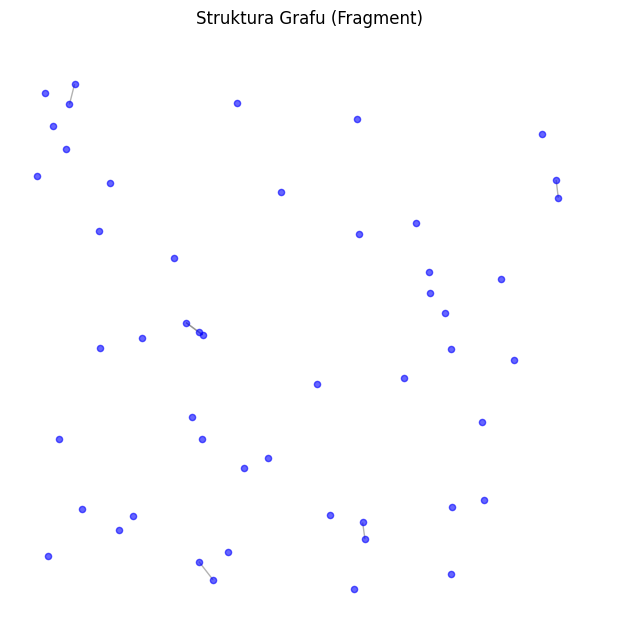

In [8]:
# Budujemy graf NSW (z użyciem NetworkX)
G = nx.Graph()

# Dodajemy węzły
for i in range(num_points):
    G.add_node(i, pos=points[i])

# Dodajemy krawędzie (Każdy łączy się z 3 najbliższymi)
# To jest etap "Indeksowania" (robimy to raz, offline)
from sklearn.neighbors import NearestNeighbors

k = 3
knn = NearestNeighbors(n_neighbors=k+1).fit(points) # +1 bo punkt jest swoim sąsiadem
distances, indices = knn.kneighbors(points)

for i in range(num_points):
    for neighbor_idx in indices[i][1:]: # Pomijamy index 0 (siebie)
        G.add_edge(i, neighbor_idx)

print("🕸️ Graf NSW zbudowany. Możemy po nim nawigować.")
# Rysujemy fragment grafu
plt.figure(figsize=(6, 6))
# Rysujemy tylko pierwsze 50 punktów dla czytelności
sub_nodes = list(range(50))
sub_G = G.subgraph(sub_nodes)
pos = {i: points[i] for i in sub_nodes}
nx.draw(sub_G, pos, node_size=20, node_color='blue', edge_color='gray', alpha=0.6)
plt.title("Struktura Grafu (Fragment)")
plt.show()

## Algorytm Greedy Search (Chciwe szukanie)

To jest serce HNSW.
1.  Wchodzimy do grafu w losowym punkcie (Entry Point).
2.  Patrzymy na sąsiadów.
3.  Czy któryś z sąsiadów jest bliżej celu (Query) niż my?
    *   **TAK:** Przeskakujemy na niego. Powtórz.
    *   **NIE:** Jesteśmy w lokalnym minimum. To jest nasz wynik.

Nie sprawdzamy całej bazy. Sprawdzamy tylko ścieżkę!

In [9]:
def greedy_graph_search(graph, dataset, q, entry_point_idx):
    current_node = entry_point_idx
    path = [current_node] # Do wizualizacji
    
    # Dystans startowy
    best_dist = np.linalg.norm(dataset[current_node] - q)
    
    while True:
        # Pobierz sąsiadów obecnego węzła
        neighbors = list(graph.neighbors(current_node))
        
        # Sprawdź, czy któryś sąsiad jest lepszy
        moved = False
        for neighbor in neighbors:
            dist = np.linalg.norm(dataset[neighbor] - q)
            
            if dist < best_dist:
                best_dist = dist
                current_node = neighbor
                path.append(current_node)
                moved = True
                # W wersji Greedy idziemy do pierwszego lepszego, albo najlepszego z sąsiadów.
                # Tutaj upraszczamy: jak znajdziemy lepszego, skaczemy.
        
        if not moved:
            break # Utknęliśmy w dołku (Local Minimum)
            
    return current_node, path

# Testujemy
# Zaczynamy z punktu nr 0 (losowy start)
entry_point = 0 
found_idx, search_path = greedy_graph_search(G, points, query, entry_point)

print(f"Start: {entry_point}")
print(f"Kroki (ścieżka): {len(search_path)}")
print(f"Znaleziony punkt: {found_idx}")
print(f"Prawdziwy najlepszy: {true_best_idx}")

if found_idx == true_best_idx:
    print("✅ SUKCES! Znaleźliśmy ten sam punkt co Brute Force.")
else:
    print("⚠️ PRZYBLIŻENIE. Znaleźliśmy lokalne minimum (blisko, ale nie idealnie).")

Start: 0
Kroki (ścieżka): 12
Znaleziony punkt: 402
Prawdziwy najlepszy: 137
⚠️ PRZYBLIŻENIE. Znaleźliśmy lokalne minimum (blisko, ale nie idealnie).


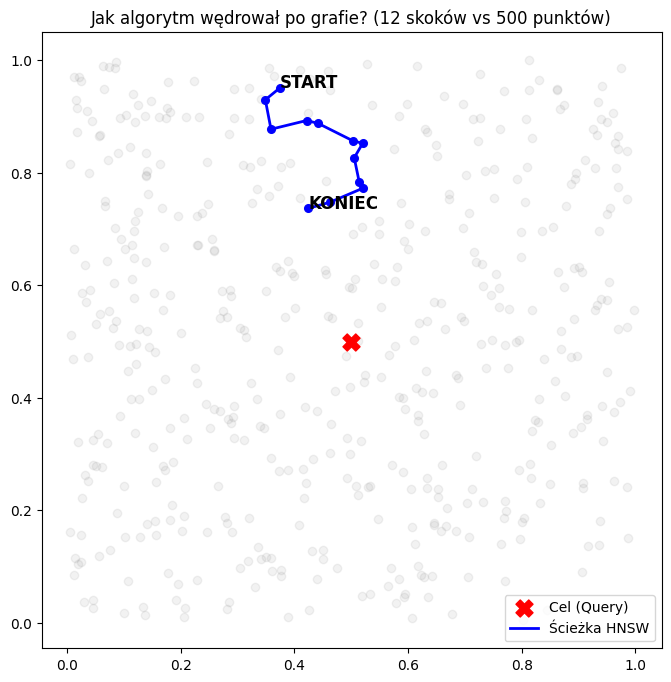

In [10]:
# WIZUALIZACJA ŚCIEŻKI
plt.figure(figsize=(8, 8))

# Wszystkie punkty
plt.scatter(points[:,0], points[:,1], c='gray', alpha=0.1)

# Cel
plt.scatter(query[0], query[1], c='red', s=150, marker='X', label='Cel (Query)')

# Ścieżka
path_points = points[search_path]
plt.plot(path_points[:,0], path_points[:,1], c='blue', linewidth=2, label='Ścieżka HNSW')
plt.scatter(path_points[:,0], path_points[:,1], c='blue', s=30)

# Start i Koniec
plt.text(path_points[0,0], path_points[0,1], "START", fontsize=12, fontweight='bold')
plt.text(path_points[-1,0], path_points[-1,1], "KONIEC", fontsize=12, fontweight='bold')

plt.title(f"Jak algorytm wędrował po grafie? ({len(search_path)} skoków vs {num_points} punktów)")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Logarytmiczna Prędkość

Spójrz na wynik.
Mieliśmy 500 punktów.
Brute Force musiał sprawdzić **500 dystansów**.
HNSW sprawdził tylko **kilka/kilkanaście** (tyle ile kroków na ścieżce + ich sąsiedzi).

Dla 500 punktów to bez znaczenia.
Dla **100 milionów punktów**:
*   Brute Force: 100 000 000 operacji (Sekundy/Minuty).
*   HNSW: ~50 operacji (Milisekundy).

**Cena:**
HNSW jest przybliżony (Approximate). Czasem utknie w lokalnym minimum i nie znajdzie idealnie najbliższego sąsiada, ale znajdzie "wystarczająco bliskiego". W RAG to w zupełności wystarcza.